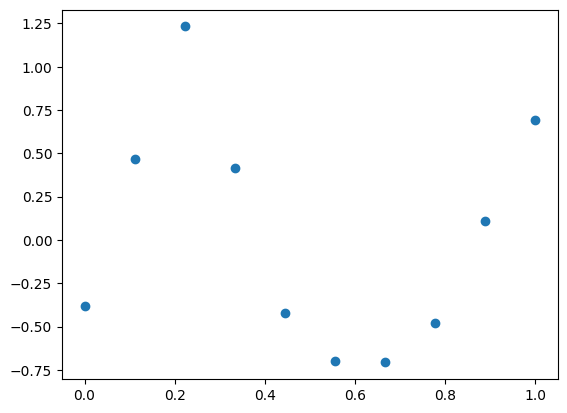

In [2]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from known_boundary.SLogGP import SLogGP

np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,10).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

plt.scatter(X_test,Y_test)

In [3]:
# Test MLE method
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
opt_model_MLE(X_test,Y_test,1,'SLogGP',noise=1e-6,seed=1234,lengthscale_range=[0.01,1],variance_range=[0.01**2,10],c_range=[0.78,10]) 

 /home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


[0.2332867624281936, 1.00412117746481, 0.963767523123562]

now lower bound is:  -0.3222856938177987


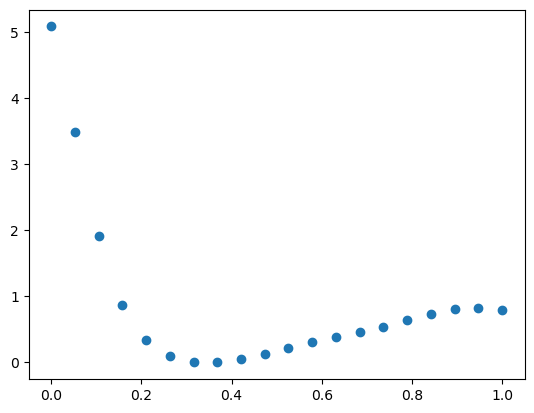

In [11]:
# Test MAP method, we need to make sure the range of c is positive, so we shift the current Y so that min(Y)=0
np.random.seed(0)


X_init = np.array([0.0]).reshape(-1,1)
Y_init = np.array([0.0]).reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.2,variance=0.5)  #np.sqrt(res[0])
model_test = GPy.models.GPRegression(X_init, Y_init,kernel)

X_test = np.linspace(0,1,20).reshape(-1,1)
Y_test = np.exp(0.5+model_test.posterior_samples_f(X_test,size=1).reshape(-1,1))-1

print('now lower bound is: ',-1- np.min(Y_test))
Y_test = Y_test - np.min(Y_test)
plt.scatter(X_test,Y_test)

In [14]:
#MLE 
opt_model_MLE(X_test,Y_test,1,'SLogGP',noise=1e-6,seed=1234,lengthscale_range=[0.01,1],variance_range=[0.01**2,10],c_range=[0.,10]) 

[0.23109151717602844, 1.0553667167890315, 0.34705230804299864]

In [12]:
#MAP with strong prior
opt_model_MAP(X_test,Y_test,1,lengthscale_range=[0.01,1],variance_range=[0.01**2,10],prior_parameter=[0,0.1],noise=1e-5,seed=1234)

[0.1864489854406809, 0.38112165389730446, 0.8962671569348132]

In [16]:
#MAP with weak prior
opt_model_MAP(X_test,Y_test,1,lengthscale_range=[0.01,1],variance_range=[0.01**2,10],prior_parameter=[0,5],noise=1e-5,seed=1234)

[0.23096832365237516, 1.0672511704816974, 0.3368516155561848]

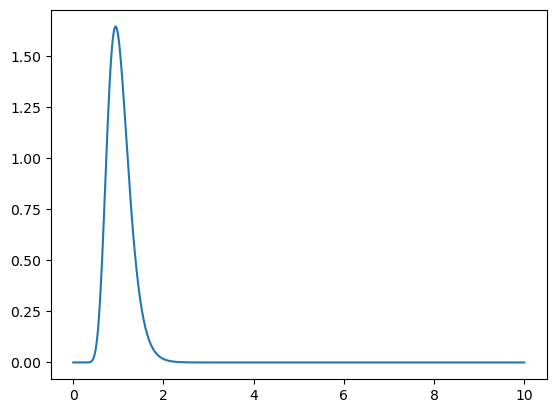

In [21]:
from scipy import stats
import math 

pdf_function = stats.lognorm(s=0.25, scale=math.exp(0))

X_total = np.linspace(0,10,500) 
pdf_holder = []
for x in X_total:
    res = pdf_function.pdf(x)
    pdf_holder.append(res)

plt.plot(X_total,np.array(pdf_holder))

# artifical function try

In [17]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell,SixHumpCamel
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


In [21]:
lengthscale_range = [0.03,2]
variance_range = [0.01**2,16]
noise = 1e-6

In [30]:
fun = Branin(negate=False)

dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

if dim <=3:
    step_size = 2
elif dim<=7:
    step_size = 3
else:
    step_size = 4
    
n_init = 4*dim
iter_num = 50
N = 20

fstar = 0.397887

In [31]:
for exp in range(1):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    print(best_record[-1])
    np.random.seed(1234)

    for i in range(50):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
            print('shift lower bound: ',fstar_shifted)
            train_Y = train_Y - np.min(train_Y)
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
    
            
            # train_Y_std = np.std(train_Y)
            # lower = -np.min(train_Y)+10**(-6)
            # upper = lower+min(300,5*train_Y_std)
            
            # c_range = [lower,upper]
            
            # here is the rule of determing the prior parameter: we set the median = f^b+0.3, the mode = f^b, so prior mean and prior sigma can be calculated as:
            mu_prior = np.log(-fstar_shifted+0.3)
            sigma_prior = np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
            
            #prior_parameter = [np.log(-fstar_shifted)+0.3**2,0.3]
            prior_parameter = [mu_prior,sigma_prior]
            
            if i%step_size == 0:
                
                best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
                

    
                lengthscale = best_parameter[0]
                variance = best_parameter[1]
                c = best_parameter[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('c: ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            # print('x chosen: ',X_next)
            # print('Y: ', Y_next)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print('!!!!best so far: ',best_record[-1])
            
    best_record = np.array(best_record)      

0
3.5451968551073154
inner loop:  0
shift lower bound:  -3.1473098551073155
lengthscale:  0.26342571949493065
variance:  1.1957902963554008
c:  3.481122266211731
!!!!best so far:  3.5451968551073154
inner loop:  1
shift lower bound:  -3.1473098551073155
!!!!best so far:  3.5451968551073154
inner loop:  2
shift lower bound:  -3.1473098551073155
lengthscale:  0.09133799096251885
variance:  0.9528465205451029
c:  3.3797731766491625
!!!!best so far:  2.0961476851422445
inner loop:  3
shift lower bound:  -1.6982606851422446
!!!!best so far:  2.0961476851422445
inner loop:  4
shift lower bound:  -1.6982606851422446
lengthscale:  0.08472512559480519
variance:  1.3039768647853636
c:  2.0221943127303823
!!!!best so far:  0.9730607217846874
inner loop:  5
shift lower bound:  -0.5751737217846874
!!!!best so far:  0.8930522690846345
inner loop:  6
shift lower bound:  -0.49516526908463454
lengthscale:  0.06527883989033095
variance:  2.0841857021408647
c:  0.8446532854392546
!!!!best so far:  0.8132

In [16]:
# sigma =0.1
best_record

array([15.1367623 ,  6.03907116,  6.03907116,  1.97234647,  1.97234647,
        0.73031977,  0.66464265,  0.66464265,  0.37529035,  0.37529035,
        0.37529035,  0.37529035,  0.26357006,  0.26357006,  0.0946659 ,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226,  0.05868226,  0.05868226,  0.05868226,  0.05868226,
        0.05868226])

In [23]:
# sigma =0.3
best_record

array([41.54106802, 41.54106802, 31.96256655, 31.96256655, 31.96256655,
       31.96256655,  2.15406225,  2.15406225,  2.15406225,  2.15406225,
        2.15406225,  2.15406225,  2.15406225,  2.15406225,  2.15406225,
        2.15406225,  2.15406225,  2.15406225,  2.15406225,  2.15406225,
        2.15406225,  2.15406225,  2.15406225,  2.15406225,  2.15406225,
        2.15406225,  2.15406225,  2.15406225,  2.15406225,  2.15406225,
        2.15406225,  2.15406225,  0.98908784,  0.98908784,  0.98908784,
        0.98908784,  0.98908784,  0.98908784,  0.98908784,  0.98908784,
        0.98908784,  0.98908784,  0.98908784,  0.98908784,  0.98908784,
        0.98908784,  0.98908784,  0.98908784,  0.98908784,  0.98908784,
        0.98908784])

In [26]:
# sigma =5.
best_record

array([41.54106802,  8.23813727,  8.23813727,  8.23813727,  8.23813727,
        8.23813727,  8.23813727,  8.23813727,  8.23813727,  8.23813727,
        8.23813727,  8.23813727,  5.85017703,  1.10632534,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.78762335,  0.78762335,  0.78762335,  0.78762335,  0.78762335,
        0.73280084])

In [6]:
for exp in range(1):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    print(best_record[-1])
    np.random.seed(1234)

    for i in range(50):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
            print('shift lower bound: ',fstar_shifted)
            train_Y = train_Y - np.min(train_Y)
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
    
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+min(300,5*train_Y_std)
            
            c_range = [lower,upper]
            
            if i%step_size == 0:
                
                parameter_num = 3
                restart_num = int(3**parameter_num/1)+1
                
                obj_holder = []
                parameter_holder = []
                
                for ii in range(restart_num):
                    
                    np.random.seed(ii)
                    
                    lengthscale_init = np.random.uniform(lengthscale_range[0],lengthscale_range[1],1)[0]
                    variance_init = np.random.uniform(variance_range[0],variance_range[1],1)[0]
                    c_init = np.random.uniform(c_range[0],c_range[1],1)[0]
                    
                    prior = GPy.priors.LogGaussian(mu=np.log(-fstar_shifted)+0.3**2, sigma=0.3) ########## prior
                    
                    m = GPy.models.WarpedGP(train_X.reshape(-1,dim), train_Y.reshape(-1,1),warping_function=SLogGP(lower=c_range[0],upper=c_range[1],n_terms =1,psi_bound = False))
                    m.SlogGP.psi.set_prior(prior, warning=False) ########## prior
                    
                    m.rbf.lengthscale = lengthscale_init
                    m.rbf.variance = variance_init
                    m.SlogGP.psi = c_init
                    
                    m.rbf.lengthscale.constrain_bounded(lengthscale_range[0],lengthscale_range[1])
                    m.rbf.variance.constrain_bounded(variance_range[0],variance_range[1])
                    m.Gaussian_noise.fix(noise) 
                    
                    m.optimize()
                    
                    obj_temp = -m.log_likelihood()
                    lengthscale_temp = m.rbf.lengthscale.item()
                    variance_temp = m.rbf.variance.item()
                    c_temp = m.SlogGP.psi.item()
                    
                    obj_holder.append(obj_temp)
                    parameter_holder.append([lengthscale_temp,variance_temp,c_temp])
                    
                index = np.argmin(obj_holder)
                best_parameter = parameter_holder[index]
                

    
                lengthscale = best_parameter[0]
                variance = best_parameter[1]
                c = best_parameter[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('c: ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            # print('x chosen: ',X_next)
            # print('Y: ', Y_next)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print('!!!!!!!!!!best so far: ',best_record[-1])
            
    best_record = np.array(best_record)         


0
3.5451968551073154
inner loop:  0
shift lower bound:  -3.1473098551073155
lengthscale:  0.26339416008587946
variance:  1.1964954928598186
c:  3.4771599650912517
!!!!!!!!!!best so far:  3.5451968551073154
inner loop:  1
shift lower bound:  -3.1473098551073155
!!!!!!!!!!best so far:  3.5451968551073154
inner loop:  2
shift lower bound:  -3.1473098551073155
lengthscale:  0.09133488391319614
variance:  0.9533253843364229
c:  3.377039662111478
!!!!!!!!!!best so far:  2.096140736131769
inner loop:  3
shift lower bound:  -1.698253736131769
!!!!!!!!!!best so far:  2.096140736131769
inner loop:  4
shift lower bound:  -1.698253736131769
lengthscale:  0.0828303804526613
variance:  1.347301448847083
c:  1.874938497661135
!!!!!!!!!!best so far:  0.9838178023341388
inner loop:  5
shift lower bound:  -0.5859308023341389
!!!!!!!!!!best so far:  0.8834974929246506
inner loop:  6
shift lower bound:  -0.48561049292465064
lengthscale:  0.06022994061028977
variance:  2.3935422476618764
c:  0.538052329912

In [80]:
# enforce the boundary
best_record

array([3.54519686, 3.54519686, 3.54519686, 2.09512436, 2.09512436,
       1.1813443 , 0.89090841, 0.79172825, 0.5265024 , 0.50493566,
       0.50493566, 0.50493566, 0.50493566, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.47913056,
       0.47913056, 0.47913056, 0.47913056, 0.47913056, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952, 0.42776952, 0.42776952, 0.42776952, 0.42776952,
       0.42776952])

In [7]:
# sigma = 0.3
best_record

array([3.54519686, 3.54519686, 3.54519686, 2.09614074, 2.09614074,
       0.9838178 , 0.88349749, 0.84982086, 0.49092453, 0.49092453,
       0.49092453, 0.49092453, 0.49092453, 0.49092453, 0.49092453,
       0.49092453, 0.49092453, 0.49092453, 0.40918587, 0.40918587,
       0.40918587, 0.40918587, 0.40918587, 0.40918587, 0.40918587,
       0.40918587, 0.40918587, 0.40918587, 0.40192455, 0.40192455,
       0.40192455, 0.40192455, 0.40192455, 0.40192455, 0.40192455,
       0.40192455, 0.40192455, 0.40192455, 0.40192455, 0.40192455,
       0.40192455, 0.39873774, 0.39873774, 0.39873774, 0.39873774,
       0.39873774, 0.39873774, 0.39873774, 0.39873774, 0.39873774,
       0.39873774])

In [32]:
best_record

array([3.54519686, 3.54519686, 3.54519686, 2.09614769, 2.09614769,
       0.97306072, 0.89305227, 0.81322549, 0.49177956, 0.49177956,
       0.49177956, 0.49177956, 0.49177956, 0.49177956, 0.49177956,
       0.49177956, 0.49177956, 0.49177956, 0.49177956, 0.49177956,
       0.49177956, 0.49177956, 0.49177956, 0.49177956, 0.49177956,
       0.49177956, 0.49177956, 0.40815312, 0.40815312, 0.40815312,
       0.40815312, 0.40815312, 0.40815312, 0.40815312, 0.40815312,
       0.40815312, 0.40815312, 0.40815312, 0.40815312, 0.39892201,
       0.39854845, 0.39854845, 0.39854845, 0.39854845, 0.39854845,
       0.39831355, 0.39831355, 0.39797059, 0.39797059, 0.39792817,
       0.39792817])

In [84]:
# sigma = 1
best_record

array([3.54519686, 3.54519686, 3.54519686, 0.70990423, 0.70990423,
       0.70990423, 0.69210527, 0.69210527, 0.69210527, 0.69210527,
       0.69210527, 0.69210527, 0.61635434, 0.61635434, 0.61635434,
       0.48115369, 0.48115369, 0.48115369, 0.48115369, 0.48115369,
       0.48115369, 0.48115369, 0.48115369, 0.48115369, 0.48115369,
       0.48115369, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39864212, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39864212, 0.39864212, 0.39864212, 0.39864212, 0.39864212,
       0.39835139, 0.39835139, 0.39835139, 0.39835139, 0.39835139,
       0.39805497, 0.39805497, 0.39792541, 0.39792541, 0.39792541,
       0.39792541])